<a href="https://colab.research.google.com/github/Emaperidol/AI_ML_Healthcare/blob/main/Tweets_Classification_Assignment13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task: Identify Real Disasters from Tweets

In this assignment, you will build a neural network model to classify tweets into non-disasters related and disasters related.

## Disaster Tweets
Source: https://www.kaggle.com/datasets/vstepanenko/disaster-tweets?resource=download

\
The dataset contains over 11,000 tweets associated with disaster keywords like “crash”, “quarantine”, and “bush fires” as well as the location and keyword itself.

\
Then the text were manually classified whether the tweet referred to a disaster event or not (a joke with the word or a movie review or something non-disastrous).

\
The data structure were inherited from Disasters on social media (https://www.figure-eight.com/data-for-everyone/).


\
The two labels/targets are:
* 0: non-disasters
* 1: disasters

###Q1.

Read in the dataset as a Pandas DataFrame.

In [2]:
import pandas as pd
import numpy as np
from google.colab import files

uploaded = files.upload()
df = pd.read_csv('tweets.csv')

Saving tweets.csv to tweets (1).csv


###Q2.
Rename the column 'target' 'label', and drop the three columns: 'id', 'keyword', and 'location'.

In [3]:
df.rename(columns={'target': 'label'}, inplace=True)
df.drop(['id', 'keyword', 'location'], axis=1, inplace=True)


###Q3.
Look at the class distribution by plotting a horizontal bar chart. Do you have a balanced or unbalanced dataset? Which class is the minority?

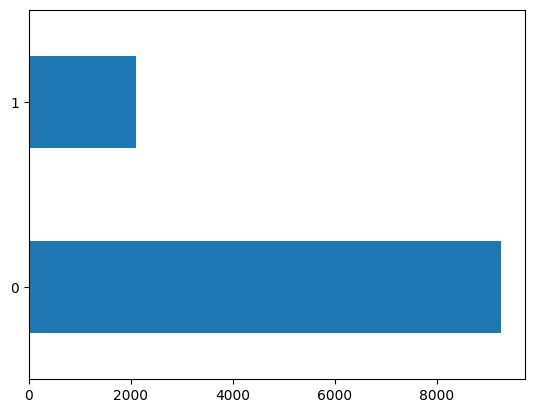

In [4]:
import matplotlib.pyplot as plt

df['label'].value_counts().plot(kind='barh')
plt.show()



**Unbalanced, non-disaster tweets are the minority**

###Q4.
Take a look at the length of tweets using boxplot, stratified by sentiment. Remember to remove the columns, if any, that you have added to the DataFrame in Q3 and Q4.

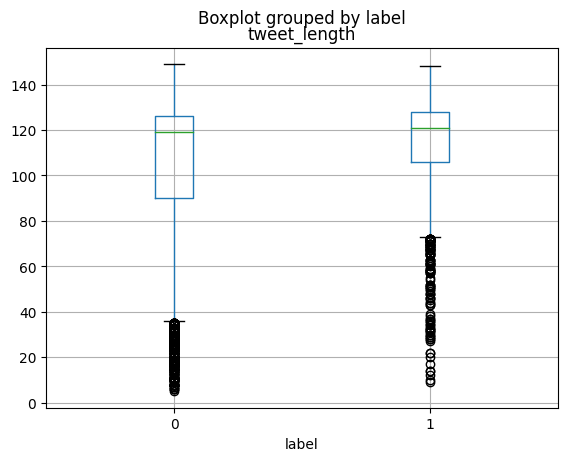

In [5]:
df['tweet_length'] = df['text'].apply(len)
df.boxplot(column='tweet_length', by='label')
plt.show()
df.drop(['tweet_length'], axis=1, inplace=True)


###Q5.
Split the data into 80% train, 10% validation, and 10% test using sklearn.

In [6]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)

###Q6.
Convert the three DataFrames to three Datasets (Aparche Arrow format).

In [7]:
!pip install datasets
from datasets import Dataset

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)


###Q7.
Gather train, val, and test Datasets to have a single DatasetDict, which can be manipulated together later.

In [8]:
from datasets import DatasetDict

dataset_dict = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

###Q8.
Specify the model checkpoint. Load the tokenizer from the pretrained model. You are free to choose the model from the Huggingface Hub.

Hint: Think about what models are more suitable to your task at hand, which is to classify tweet texts. In particular, recall the ULMFiT framework you have learned from the previous lecture.

In [9]:
!pip install accelerate==0.20.3
import transformers
from transformers import AutoTokenizer

model_checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

###Q9.
Tokenize the entire DatasetDict.

Hint: You may first define a precessing function to tokenize a batch of examples, and then use the map() methods on your DatasetDict object.

In [10]:
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True)

tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)

Map:   0%|          | 0/9096 [00:00<?, ? examples/s]

Map:   0%|          | 0/1137 [00:00<?, ? examples/s]

Map:   0%|          | 0/1137 [00:00<?, ? examples/s]

###Q10.
Remove the 'text' column from the encoded DatasetDict because the model does not use it. Then convert the 'input_ids' and 'attention_mask' columns to PyTorch format using the set_format() function.

In [11]:
tokenized_datasets = tokenized_datasets.remove_columns(['text'])
tokenized_datasets.set_format('torch')


###Q11.
Set device to 'cuda' because you will need GPU for your training.

In [12]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


###Q12.
Create two dictionaries:
```
label2id = {'disaster': '1', 'non-disaster': '0'}
id2label = {'0': 'non-disaster', '1': 'disaster'}
```
which you will need to add to the model configuration.

In [13]:
label2id = {'non-disaster': 0, 'disaster': 1}
id2label = {0: 'non-disaster', 1: 'disaster'}


###Q13.
Define the model using the `AutoModelForSequenceClassification.from_pretrained()` method.

Hint: You will need to provide the following arguments at a mimimum:
* model checkpoint
* num_labels
* label2id
* id2label

Also, remember to use to(device) method in order to fine-tune your model on GPU.

In [14]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint,
                                                           num_labels=2,
                                                           label2id=label2id,
                                                           id2label=id2label).to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


###Q14.
Define a function to compute model performance metrics. Use two metrics: F1 score and accuracy.

In [15]:
from sklearn.metrics import f1_score, accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds)
    accuracy = accuracy_score(labels, preds)
    return {"f1": f1, "accuracy": accuracy}


###Q15.
Define the training arguments using the TrainingArguments() method. There are many parameters for you to choose from. Refer to the lecture notes or here (https://huggingface.co/docs/transformers/v4.20.1/en/main_classes/trainer#transformers.TrainingArguments) for more information.

In [16]:
from transformers import trainer
from transformers import TrainingArguments
import transformers



In [17]:
TA = TrainingArguments(
    output_dir="./results",       # Directory for saving and loading model files
    evaluation_strategy="steps",  # Evaluation is done (and model saved) at each specified step
    save_total_limit=3,           # Only last 3 models are saved. Older ones are deleted
    num_train_epochs=3,           # Total number of training epochs
    per_device_train_batch_size=16,  # Batch size per device during training
    per_device_eval_batch_size=64,   # Batch size for evaluation
    warmup_steps=500,             # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,            # Strength of weight decay
    logging_dir='./logs',         # Directory for storing logs
    logging_steps=10,             # Log every X updates steps
)


###Q16.
Define the trainer using the Trainer() method.

Hint: You will need the following arguments there:
* model
* training arguments
* metrics
* train and validation Datasets
* tokenizer

In [18]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=TA,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)


###Q17.
Now you can start the training process using the train() method. Make sure to document and show your training history table, which shows the epoch-specific training loss, validation loss, accuracy, and F1 score. At which epoch do you get the highest accuracy and F1 score? What are their values? Are you satisfied by the model performance? If so, why? If not, what do you propose to futher improve model performance?

In [18]:
# Took too much GPU
trainer.train()


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,F1,Accuracy
10,0.514800,0.488314,0.009615,0.818821


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-3435b262f1ae>", line 1, in <cell line: 1>
    trainer.train()
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer.py", line 1555, in train
    return inner_training_loop(
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer.py", line 1922, in _inner_training_loop
    self._maybe_log_save_evaluate(tr_loss, model, trial, epoch, ignore_keys_for_eval)
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer.py", line 2271, in _maybe_log_save_evaluate
    metrics = self.evaluate(ignore_keys=ignore_keys_for_eval)
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer.py", line 3011, in evaluate
    output = eval_loop(
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer.py", line 3222, in evaluation_l


KeyboardInterrupt



Reached max GPU usage on google colab

###Q18.
Plot the confusion matrix on the validation Dataset.

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


<Axes: >

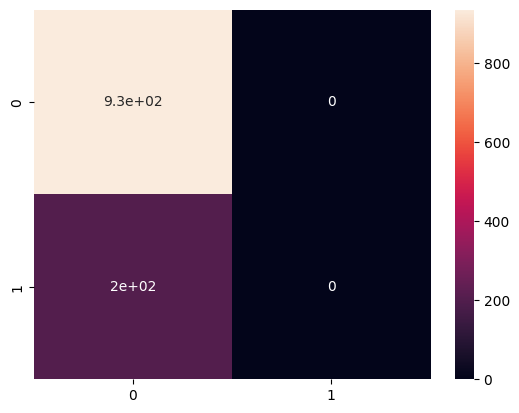

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


predictions = trainer.predict(tokenized_datasets["validation"])
predicted_labels = predictions.predictions.argmax(-1)

cm = confusion_matrix(tokenized_datasets["validation"]["label"], predicted_labels)
sns.heatmap(cm, annot=True)


###Q19.
What the accuracy and F1 score on the test Dataset?

In [20]:
# I couldnt actually train the model due to max GPU usage
test_results = trainer.evaluate(tokenized_datasets["test"])
print(test_results)


{'eval_loss': 0.4965158998966217, 'eval_f1': 0.0, 'eval_accuracy': 0.830255057167986, 'eval_runtime': 44.9956, 'eval_samples_per_second': 25.269, 'eval_steps_per_second': 0.4}


###Q20.
Save the fine-tuned model as well as its correponding tokenizer to a specified folder on your Google Drive.

In [21]:
model.save_pretrained('./model_save')
tokenizer.save_pretrained('./model_save')


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json',
 './model_save/tokenizer.json')

###Q21.
Load your saved model and tokenizer using the pipeline() method.

Hint: Specify your pipeline as 'text-classification' so that you can use the pipeline for text classification tasks.

In [22]:
from transformers import pipeline

loaded_model = pipeline("text-classification", model='./model_save', tokenizer='./model_save')


###Q22.
Test your text classification pipeline for the following tweet: 'It would be a disaster to spoil a young child!' What is the pipeline's prediction? Does it make sense to you?

In [23]:
# Example tweet
print(loaded_model('It would be a disaster to spoil a young child!'))


[{'label': 'non-disaster', 'score': 0.7095734477043152}]


###Q23.
Test your text classification pipeline for the following tweet: 'An earthquake of magnitude 6.5 struck Crete, Greece on Monday.' What is the pipeline's prediction? Does it make sense to you?

In [24]:

# Example tweet
print(loaded_model('An earthquake of magnitude 6.5 struck Crete, Greece on Monday.'))


[{'label': 'non-disaster', 'score': 0.7545270323753357}]


###Q24.
This is a bonus question so it can be a little bit challenging. Recall that the classes are imbalanced in your data: You have a lot more 'non-disaster' related tweets than 'disaster' related tweets. But why is an imbalanced classification problematic?

\
An imbalanced classification problem is an example of a classification problem where the distribution of examples across the known classes is biased or skewed. The distribution can vary from a slight bias to a severe imbalance where there is one example in the minority class for hundreds, thousands, or millions of examples in the majority class or classes.

\
Imbalanced classifications pose a challenge for predictive modeling as most of the machine learning algorithms used for classification were designed around the assumption of an equal number of examples for each class. This results in models that have poor predictive performance, specifically for the minority class. This is a problem because typically, the minority class is more important and therefore the problem is more sensitive to classification errors for the minority class than the majority class.

\
To address imbalanced classification problem, you can surely collect more data, in this case, more 'disaster' related tweets. But if you do not have the time and resources to do that, what else can you do? One (statistical) way to deal with imbalanced data is to oversample the minority class (or undersample the majority class) so that the resampled classes are balanced in the train set (Note: you do NOT want to resample the validation set or test set because of data leaking concern). There are many APIs that can do that for you, and a popular one is `imbalanced-learn`: https://imbalanced-learn.org/stable/

\
Your task is to figure out a way to implement one (out of the several available) oversampling strategies offered by the `imbalanced-learn` module to create a balanced dataset, and use that dataset to finet-tune a pre-trained model. You will need to report the model performance metrics on the test set. Comparing the metric to that obtained from using the original, imbalanced dataset, which model is better?

In [26]:
from imblearn.over_sampling import SMOTE
from datasets import Features, ClassLabel, Value

# Oversampling
smote = SMOTE()
train_features, train_labels = smote.fit_resample(X, y)

# Convert back to Dataset
oversampled_train_dataset = Dataset.from_pandas(pd.DataFrame(train_features), pd.Series(train_labels))


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 6>:6                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'X' is not defined